# Dummies guide to Fourier Transform

We've all seen those weird looking mathematics equations that pop up when we hear about **Fourier transforms**. In this blog post, we'll programatically try and develop an intuitive understanding into the whole process. While I'll be using the scientific Python stack in this blog post, code in Matlab, R should not be that different. 

### Goal: Given a time series signal, we'll try and decompose it into various contituent freqencies.

First, let us assume that we are doing some signal acquisition and we can sample at 100 Hz frequency (100 times per second). We collect data for 10 seconds. So, we have a total of 1000 samples. 

```python
Samples collection duration (T) = 10s
Sampling frequency (Fs) =100Hz
Number of samples (N) = Ts*Fs=1000
```

It must be noted that Fs is the rate at which we are able to sample. Let us now create a signal composed of different frequencies. 

### Code preliminaries

I'll import a few packages necessary for the post. Numpy is a fundamental package in the scientific Python stack and provides array operations. We'll use matplotlib for the plots. I'm also importing the warnings module to suppress any warnings in the code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


Let us create a simple function to generate sine and cosine waves given the time for which samples were collected, the frequency of sampling and the frequency of the desired sine wave. 

In [2]:
def create_sine(t, fs, frequency_of_sine):
    return np.sin(2*np.pi*frequency_of_sine*np.arange(0, t, 1./fs))
def create_cosine(t, fs, frequency_of_cosine):
    return np.cos(2*np.pi*frequency_of_cosine*np.arange(0, t, 1./fs))

Let us now plot a sample sine wave of 1 Hz where our instrument can sample at 100 Hz and we acquire the data for 10 seconds.  

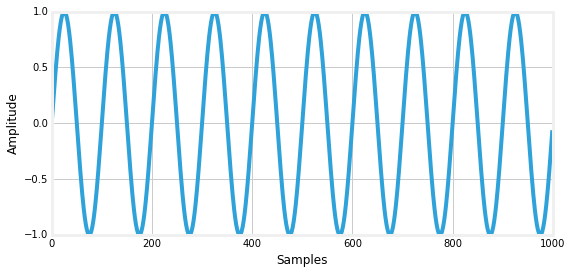

In [3]:
plt.figure(figsize=(8,4))
plt.plot(create_sine(10, 100, 1))
plt.xlabel("Samples")
plt.ylabel("Amplitude");

Great! We can see 10 time periods of our sine wave in 10 seconds. Thus, our sine wave creation functin seems to be working correct :) Please ensure that you notice that the x-axis is the number of samples and not time. 1000 samples were collected in 10 seconds.

### Creating the signal for processing

We will now create our dummy signal. It will be composed of four sinusoidal sine waves of different frequencies: 0 Hz (DC), 10 Hz, 2 Hz and 0.5 Hz. Did I introduce a new term here- DC. DC refers to direct current. Yes, the same direct current you might have heard in school. 

In [4]:
t = 10
fs = 100
N = t*fs
num_components = 4

components = np.zeros((num_components, N))
components[0] = np.ones(N)
components[1] = create_sine(t, fs, 10)
components[2] = create_sine(t, fs, 2)
components[3] = create_sine(t, fs, 0.5)


Plotting these four components individually.

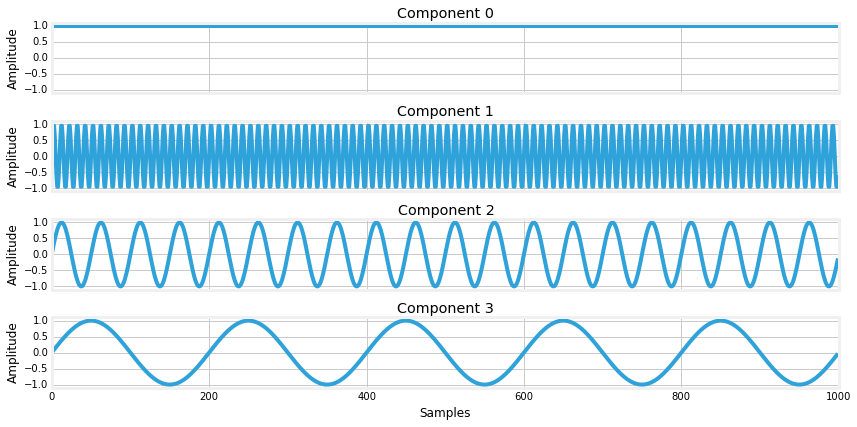

In [5]:
fig, ax  = plt.subplots(nrows=num_components, sharex=True, figsize=(12,6))
for i in range(num_components):
    ax[i].plot(components[i])
    ax[i].set_ylim((-1.1, 1.1))
    ax[i].set_title('Component {}'.format(i))
    ax[i].set_ylabel("Amplitude")
ax[num_components-1].set_xlabel("Samples")
plt.tight_layout()

Let our signal be 

$$x = -0.5\times x_0 + 0.1\times x_1 + 0.2\times x_2 -0.6\times x_3 $$

In [6]:
x = -0.5*components[0]+0.1*components[1]+0.2*components[2]-0.6*components[3]

Our dummy signal looks something like the following

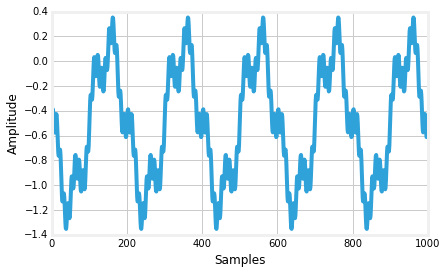

In [7]:
plt.plot(x)
plt.xlabel("Samples")
plt.ylabel("Amplitude");

By looking at the data, we might be able to notice the presence of a signal which shows five periods in 10 seconds. Or, a signal of frequency 0.5 Hz. We can also guess the presence of high frequency signals.

### Introducing DFT

For finding the various frequency components in the signal, we'll be using the Discrete Fourier Transform (DFT). The key step in DFT is to find the `correlation` between cosine waves of different frequencies with the signal that we intend to process. A high amplitude of this `correlation` indicates the presence of this frequency in our signal. 

It must be noted that the definition of `correlation` is different from the definition we encounter in statistics. Here, `correlation` between two signals simply means the dot product between the two. Please note that the dot product is the sum of the element wise product between the two signals.

Let us see the `correlation` between a few pair of signals. 

#### Correlation between a sine and a cosine of 1 Hz 

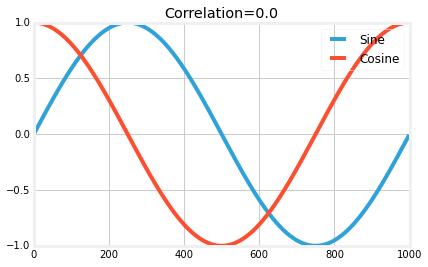

In [8]:
signal_1 = create_sine(10, 100,0.1)
signal_2 = create_cosine(10, 100,0.1 )
plt.plot(signal_1, label="Sine")
plt.plot(signal_2, label="Cosine")
plt.title("Correlation={}".format(np.sum(signal_1*signal_2)))
plt.legend();

The correlation between the sine and the cosine wave is zero. Often, the two waves are on the other side of zero. Thus, they have a zero correlation.

#### Correlation between a sine and the same sine of 1 Hz 

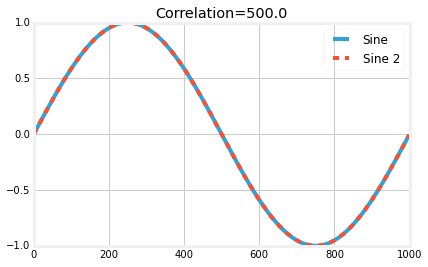

In [9]:
signal_1 = create_sine(10, 100,0.1)
signal_2 = create_sine(10, 100,0.1)
plt.plot(signal_1, label="Sine")
plt.plot(signal_2, label="Sine 2",linestyle='--')
plt.title("Correlation={}".format(np.sum(signal_1*signal_2)))
plt.legend();

The correlation of a signal with itself is high. This is the key intuition behind DFT. We'll be trying to find out those frequencies which give us high correlation with our signal.

Thus, we will now try and see the `correlation` between our signal and a cosine wave of different frequencies. We also create small helper functions to create sine and cosine waves containing `k` periods in `N` sample points.

In [10]:
def create_cosine_k_N(k, N):
    return np.cos((2*np.pi*k/N)*np.arange(N))
def create_sine_k_N(k, N):
    return np.sin((2*np.pi*k/N)*np.arange(N))

We already know that our signal contains a 0.5 Hz component. This component would correspond to 5 time periods in 10 seconds (N=1000 sample points). Let us see the `correlation` between this cosine and our signal `x`. 

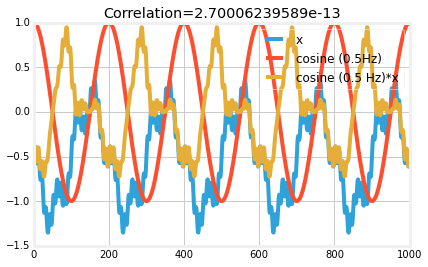

In [11]:
cos_5 = create_cosine_k_N(5,N)
plt.plot(x, label="x")
plt.plot(cos_5, label="cosine (0.5Hz)")
plt.plot(cos_5*x, label="cosine (0.5 Hz)*x")
plt.title("Correlation={}".format(np.sum(cos_5*x)))
plt.legend();

No! This correlation is so very low! But, wait a minute, how about `correlation` with the sine of the same frequency?

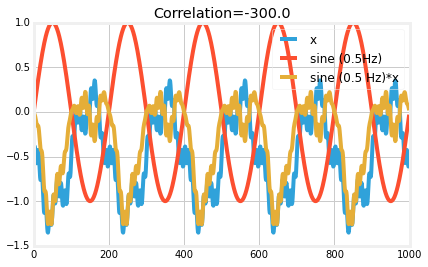

In [12]:
sin_5 = create_sine_k_N(5,N)
plt.plot(x, label="x")
plt.plot(sin_5, label="sine (0.5Hz)")
plt.plot(sin_5*x, label="sine (0.5 Hz)*x")
plt.title("Correlation={}".format(np.sum(sin_5*x)))
plt.legend();

Great! The correlation with a 0.5 Hz sinusoidal has a high amplitude. We're on to something now!
Yes, we want to detect the presence of a particular frequency and not really worry about phase for the moment. 

So, for each frequency that we find our correlation with the original signal, we can have two components- the correlation with the cosine (called the real component) and the correlation with the sine of that frequency (called the imaginary component). This is exactly what those weird looking DFT equations mean! A high absolute value of either of these components suggests the presence of that particular frequency in our signal. 

So, for every frequency in 0 to N-1 Hz, we repeat this procedure and obtain the DFT coefficients. Finally, the mathematics looks something like the following:

$ \mathrm{DFT(K)} = \sum{x_n\times \cos{\frac{2\pi K}{N}}} - \iota \sum{x_n\times \sin{\frac{2\pi K}{N}}} $

Now, if you are guessing that there is some relation with Euler's formula, you are right!

Let us repeat the procedure once again to find the presence of the 2 Hz component. For that we'll have to set K to 20. (2 Hz wave will complete 20 periods in 10 seconds).

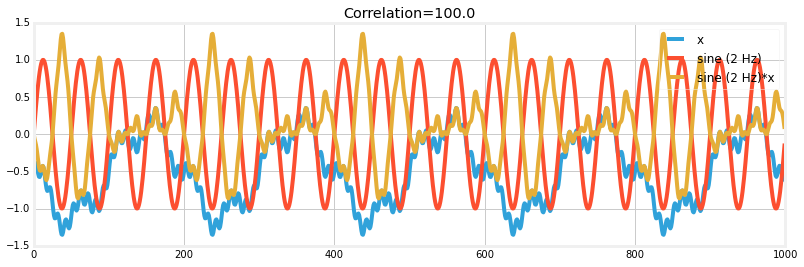

In [13]:
plt.figure(figsize=(12,4))
sin_20 = create_sine_k_N(20,N)
plt.plot(x, label="x")
plt.plot(sin_20, label="sine (2 Hz)")
plt.plot(sin_20*x, label="sine (2 Hz)*x")
plt.title("Correlation={}".format(np.sum(sin_20*x)))
plt.legend();

How about the DC component?

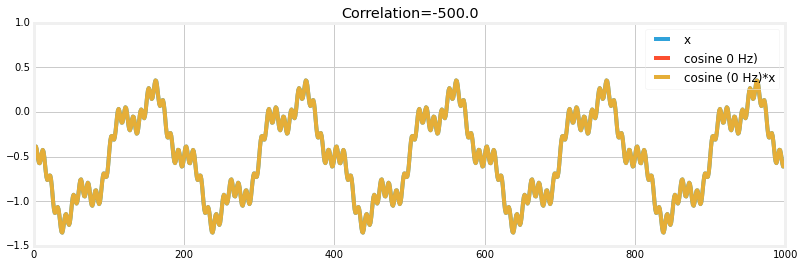

In [14]:
plt.figure(figsize=(12,4))
cos_0 = create_cosine_k_N(0,N)
plt.plot(x, label="x")
plt.plot(cos_0, label="cosine 0 Hz)")
plt.plot(cos_0*x, label="cosine (0 Hz)*x")
plt.title("Correlation={}".format(np.sum(cos_0*x)))
plt.legend();

### Using numpy's DFT implementation

Now, instead of rolling out our own implementation of DFT, we'll use the efficient inbuilt numpy DFT implementation. Now, the DFT implementation is called fft. But, let us not worry about it for the moment.

In [15]:
fft_x = np.fft.fft(x)

So, the `fft` routine returns an array of length 1000, which is equal to the number of samples. This refers to the 1000 DFT coefficients, from K=0 to 999.

In [16]:
len(fft_x)

1000

In [17]:
fft_x[0]

(-499.99999999999977+0j)

The above was the DFT coefficient for K=0. It has two components (real and imaginary) arising from the cosine and the sine waves respectively. However, we are concerned with the amplitude of the signal. This can be done by considering the absolute value of these coefficients.

We will now plot these DFT coefficients.

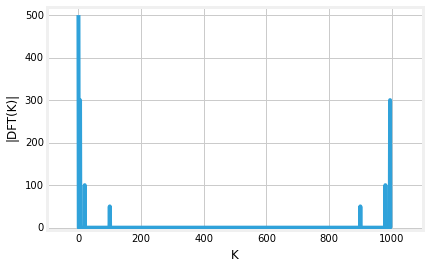

In [18]:
plt.plot(abs(fft_x))
plt.xlim((-100, 1100))
plt.ylim((-5, 520))
plt.xlabel("K")
plt.ylabel("|DFT(K)|");

Now, barring the zeroth point, the remaining signal seems to be reflected about the middle value of K. This is what we'd expect as per the Nyquist sampling criteria, sampling at fs, we can't see a signal of frequency more than fs/2. So, all that information is redundant. We'll thus plot only till fs/2 now.

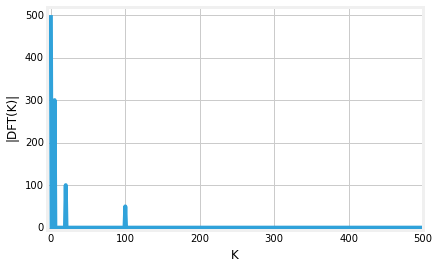

In [19]:
plt.plot(abs(fft_x)[:500])
plt.xlim((-5, 500))
plt.ylim((-5, 520))
plt.xlabel("K")
plt.ylabel("|DFT(K)|");

The above plot isn't focused enough to allow us to clearly see what's going on. So, let's restict the x axis to 120.

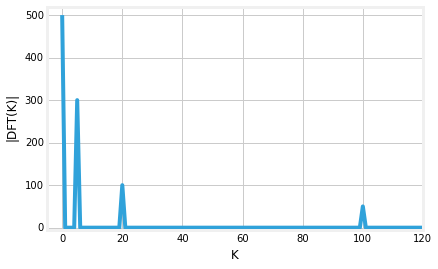

In [20]:
plt.plot(abs(fft_x)[:500])
plt.xlim((-5, 120))
plt.ylim((-5, 520))
plt.xlabel("K")
plt.ylabel("|DFT(K)|");

Ok, at K=0, 5, 20, 100, we can see spike. Now, remember that K refers to the number of periods completed in N in 10 seconds. Thus, the frequencies correpsonding to these K are: 0 Hz, 0.5 Hz, 2 Hz and 10 Hz respectively. The above plot with frequency on the x-axis would look like the following.

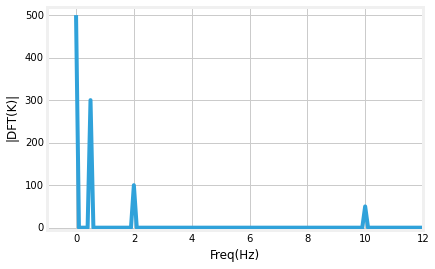

In [21]:
plt.plot(np.arange(0, 500)/10.,abs(fft_x)[:500])
plt.xlim((-1, 12))
plt.ylim((-5, 520))
plt.xlabel("Freq(Hz)")
plt.ylabel("|DFT(K)|");

### Energy preservation under the transform

The energy of the signal in the time domain is given by: $E_t = \sum(x^2)$, and in the frequency domain is given by $E_f = \sum(X^2)\times1/N$

In [27]:
Et = np.sum(x*x)
print Et

Ef = np.sum(abs(fft_x)*abs(fft_x))/N
print Ef

455.0
455.0


So, we can see that the energy is preserved under the transform. A very quick check now. How about the energy of the individual time components and their frequency transform equivalents?

Energy of DC component

In [30]:
Et_DC = np.sum(-0.5*components[0]*-0.5*components[0])
ft_DC = np.fft.fft(-0.5*components[0])
Ef_DC = np.sum(abs(ft_DC)*abs(ft_DC))/N

print(Et_DC, Ef_DC)

(250.0, 250.0)


Energy of 10 Hz component

In [31]:
Et_10hz = np.sum(0.1*components[1]*0.1*components[1])
ft_10hz = np.fft.fft(0.1*components[1])
Ef_10hz = np.sum(abs(ft_10hz)*abs(ft_10hz))/N

print(Et_10hz, Ef_10hz)

(5.0000000000000018, 5.0)


So, there you go. We can see that under the transform the energy remains the same. This also tells us how to interpret the DFT coefficients. These coefficients are an indicator of energy contribution in the aggregate signal. 

### FT of a square wave!

Can we construct a square wave from a combinations of sinusoids? Let us think the other way around. Can we decompose a square wave to get sine waves of different frequencies? Let us use our new friend's help

In [32]:
sqr_wave = np.hstack([np.ones(250), np.zeros(250), np.ones(250), np.zeros(250)])

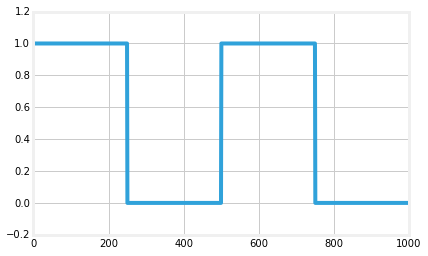

In [33]:
plt.plot(sqr_wave)
plt.ylim((-0.2,1.2));

The above is our square wave obtained under the same experimental setup as above- 100 Hz sampling for 10 seconds. Let us do a DFT on it and plot it.

In [34]:
dft_sqr = np.fft.fft(sqr_wave)

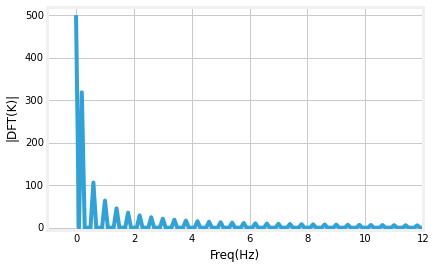

In [35]:
plt.plot(np.arange(0, 500)/10.,abs(dft_sqr)[:500])
plt.xlim((-1, 12))
plt.ylim((-5, 520))
plt.xlabel("Freq(Hz)")
plt.ylabel("|DFT(K)|");

There you go! Now, does FT sound all that difficult?

I have used a number of wonderful references for developing my understanding. I'll try and list a few here:

1. [Jake's blog post on understanding the FFT algorithm](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/)
2. [Franks's code for spectograms](http://www.frank-zalkow.de/en/code-snippets/create-audio-spectrograms-with-python.html)
3. [Glowing Python tutorial on plotting frequency spectrum](http://glowingpython.blogspot.in/2011/08/how-to-plot-frequency-spectrum-with.html)
4. [Barry's youtube tutorial on STFT](https://www.youtube.com/watch?v=NA0TwPsECUQ)
5. [R tutorial on FFT](http://www.di.fc.ul.pt/~jpn/r/fourier/fourier.html)
6. [Interactive guide to FT](http://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/)
7. [Intuitive DFT tutorial](http://practicalcryptography.com/miscellaneous/machine-learning/intuitive-guide-discrete-fourier-transform/)
8. [David's youtube video on FFT](https://www.youtube.com/watch?v=B2iUDBZzBpY)